In [187]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [188]:
torch.manual_seed(42);

In [189]:
words=open("names.txt").read().splitlines()

In [190]:
# lets make sring to charachters and charachters to string
char=sorted(list(set("".join(words))))
stoi={s:i+1 for i,s in enumerate(char)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}

In [191]:
vocab_size=len(itos)
vocab_size

27

In [192]:
import random
random.seed(42)

In [193]:
block_size=3

def build_dataset(words):
    X,Y=[],[]
    for w in words:
        context=[0]*3
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    #print(X,Y)
    return X,Y
    
random.shuffle(words)

n1=int(0.8*len(words))
n2=int(0.9*len(words))

xtr,ytr=build_dataset(words[:n1])
xval,yval=build_dataset(words[n1:n2])
xtest,ytest=build_dataset(words[n2:])

In [194]:
for x,y in zip(xtr[:20],ytr[:20]):
    print("".join(itos[ix.item()] for ix in x),'--->',itos[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


# our cusotm torch function 

In [195]:
class Linear:
    def __init__(self,fin,fout,bias=True):
        self.weight=torch.randn((fin,fout))/fin**0.5
        self.bias=torch.zeros(fout) if bias else None
        
    def __call__(self,X):
        self.out=X@self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    def parameters(self):
        return [self.weight] +([] if self.bias is None else [self.bias])

In [300]:
class BatchNorm:
    def __init__(self,dim,eps=1e-4,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        
        self.training=True
        
        self.beta=torch.zeros(dim)
        self.gamma=torch.ones(dim)
        
        #parameters during inference
            
        self.running_mean=torch.zeros(dim)
        self.running_std=torch.ones(dim)

    def __call__(self,x):
        if x.ndim==3:
            dim=0
        elif x.ndim==2:
            dim=(0,1)
            
        if self.training:
            xmean=x.mean(dim,keepdim=True)
            xstd=x.std(dim,keepdim=True)
        else:
            xmean=self.running_mean
            xstd=self.running_std
        xhat=(x-xmean)/torch.sqrt(xstd+self.eps) #this is the 
        self.out=xhat*self.gamma+self.beta
        
        #update the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
                self.running_std=(1-self.momentum)*self.running_std+self.momentum*xstd
        return self.out
        
    def parameters(self):
        return [self.gamma,self.beta]

In [197]:
class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [239]:
class Embeding:
    def __init__(self,num_embeding,emb_dim):
        self.weight=torch.randn((num_embeding,emb_dim))
        self.out=None
    def __call__(self,IX):
        self.out=self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

In [199]:
class Flatten:
    def __call__(self,x):
       self.out=x.view(x.shape[0],-1)
       return self.out
    def parameters(self):
        return []

In [277]:
class FlattenConsecutive:
    def __init__(self,n):
        self.n=n
    def __call__(self,X):
        B,T,C=X.shape
        x=X.view(B,T//self.n,C*self.n)
        if x.shape[1]==1:
            # this squeezes out the first dimension if it has the value 1
            x=x.squeeze(1)
        self.out=x
        return self.out
    def parameters(self):
        return []

In [278]:
class Sequential:
    def __init__(self,layers):
        self.layers=layers
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        self.out=x
        return self.out
        
    def parameters(self):
        return [p for layer in self.layers  for p in layer.parameters()]

In [272]:
block_size=3
n_embd=10
n_hidden=200

In [202]:
model=Sequential([
    Embeding(vocab_size,n_embd),
    Flatten(),
    Linear(n_embd*block_size,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
    layers[-1].weight*=0.1  # to make the nerual nets less sure about the first output
parameters=model.parameters()

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

12097


In [203]:
# the training and optimization
batch_size=32
max_steps=20000
lossi=[]

for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,))
    xb,yb=xtr[ix],ytr[ix]
    # the feed forward 
    x=xb
    #for layer in layers:
    #    x=layer(x)
    logits=model(x)  #this becoms the training of the model
    
    loss=F.cross_entropy(logits,yb)
    
    for p in parameters:
        p.grad=None  
    
    loss.backward()

    #update the weights
    lr=0.1 if i<10000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    if i%1000 == 0:
        print(f"the iteration {i:d} loss: {loss:.4f}")
    lossi.append(loss.log10().item())

the iteration 0 loss: 3.4953
the iteration 1000 loss: 2.5027
the iteration 2000 loss: 2.1943
the iteration 3000 loss: 2.1675
the iteration 4000 loss: 2.7574
the iteration 5000 loss: 2.2987
the iteration 6000 loss: 2.4663
the iteration 7000 loss: 2.1088
the iteration 8000 loss: 1.9378
the iteration 9000 loss: 2.7322
the iteration 10000 loss: 2.1935
the iteration 11000 loss: 2.2584
the iteration 12000 loss: 2.5940
the iteration 13000 loss: 2.1728
the iteration 14000 loss: 2.2747
the iteration 15000 loss: 2.2781
the iteration 16000 loss: 2.2272
the iteration 17000 loss: 2.2163
the iteration 18000 loss: 2.2681
the iteration 19000 loss: 2.5228


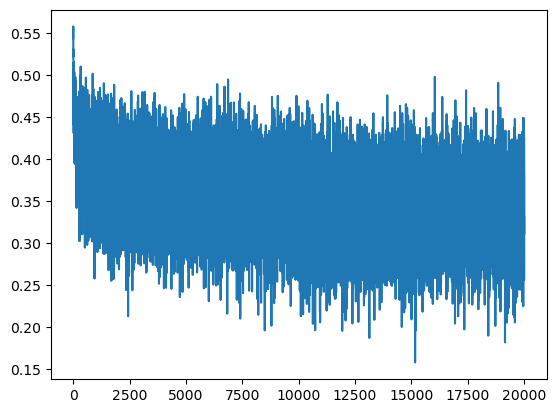

In [204]:
plt.plot(lossi)

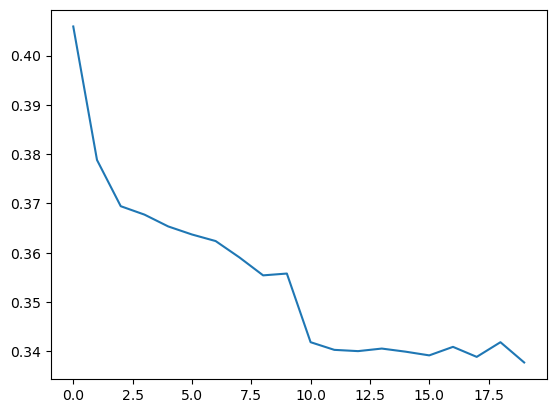

In [205]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

In [206]:
# for evaluation purposes lets set the 
for layer in model.layers:
    layer.training=False

In [207]:
# lets evaulate our model
# lets check for loss on the train and validation set
@torch.no_grad()
def split_loss(split):
    
    x,y={
        "train":(xtr,ytr),
        "valid":(xval,yval),
        "test":(xtest,ytest)
    }[split]
    logits=model(x)
    loss=F.cross_entropy(logits,y)
    print(split,loss)

split_loss("train")
split_loss("valid")

train tensor(2.1744)
valid tensor(2.1847)


In [208]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

jaealee.
nik.
paiconro.
lydenus.
jaleet.
mas.
zas.
evony.
arion.
yao.
lensera.
nastix.
pha.
kond.
millyshayle.
camaigin.
llo.
maleah.
damarcell.
grianaydarioni.


# Dilated Casual Convolutional Layer

In [301]:
block_size=8

def build_dataset(words):
    X,Y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    #print(X,Y)
    return X,Y
    
random.shuffle(words)

n1=int(0.8*len(words))
n2=int(0.9*len(words))

xtr,ytr=build_dataset(words[:n1])
xval,yval=build_dataset(words[n1:n2])
xtest,ytest=build_dataset(words[n2:])

In [214]:
for x,y in zip(xtr[:20],ytr[:20]):
    print("".join(itos[ix.item()] for ix in x),'--->',itos[y.item()])

........ ---> m
.......m ---> o
......mo ---> r
.....mor ---> g
....morg ---> a
...morga ---> n
..morgan ---> .
........ ---> f
.......f ---> i
......fi ---> l
.....fil ---> i
....fili ---> p
...filip ---> p
..filipp ---> o
.filippo ---> .
........ ---> m
.......m ---> a
......ma ---> i
.....mai ---> t
....mait ---> r


In [303]:
n_embd=24
n_hidden=128

In [304]:
model=Sequential([
    Embeding(vocab_size,n_embd), 
    FlattenConsecutive(2),Linear(n_embd*2,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2,n_hidden,bias=False),BatchNorm(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size)
])

with torch.no_grad():
    layers[-1].weight*=0.1  # to make the nerual nets less sure about the first output
parameters=model.parameters()

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

76579


In [305]:
# the training and optimization
batch_size=32
max_steps=200000
lossi=[]

for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,))
    xb,yb=xtr[ix],ytr[ix]
    # the feed forward 
    logits=model(xb)  #this becoms the training of the model
    
    loss=F.cross_entropy(logits,yb)
    
    for p in parameters:
        p.grad=None  
    
    loss.backward()

    #update the weights
    lr=0.1 if i<10000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    if i%10000 == 0:
        print(f"the iteration {i:d} loss: {loss:.4f}")
    lossi.append(loss.log10().item())

the iteration 0 loss: 3.4599
the iteration 10000 loss: 1.7518
the iteration 20000 loss: 1.9033
the iteration 30000 loss: 2.0634
the iteration 40000 loss: 1.8013
the iteration 50000 loss: 1.9511
the iteration 60000 loss: 2.2378
the iteration 70000 loss: 1.9003
the iteration 80000 loss: 1.7617
the iteration 90000 loss: 2.0126
the iteration 100000 loss: 1.9237
the iteration 110000 loss: 2.0110
the iteration 120000 loss: 1.9218
the iteration 130000 loss: 1.8481
the iteration 140000 loss: 1.8762
the iteration 150000 loss: 1.7177
the iteration 160000 loss: 1.9795
the iteration 170000 loss: 1.8743
the iteration 180000 loss: 2.0817
the iteration 190000 loss: 1.7917


In [306]:
# for evaluation purposes lets set the 
for layer in model.layers:
    layer.training=False

In [307]:
# lets evaulate our model
# lets check for loss on the train and validation set
@torch.no_grad()
def split_loss(split):
    
    x,y={
        "train":(xtr,ytr),
        "valid":(xval,yval),
        "test":(xtest,ytest)
    }[split]
    logits=model(x)
    loss=F.cross_entropy(logits,y)
    print(split,loss)

split_loss("train")
split_loss("valid")

train tensor(1.8659)
valid tensor(1.9986)


In [308]:
for layer in model.layers:
    print(layer.__class__.__name__,":",tuple(layer.out.shape))

Embeding : (22871, 8, 24)
FlattenConsecutive : (22871, 4, 48)
Linear : (22871, 4, 128)
BatchNorm : (22871, 4, 128)
Tanh : (22871, 4, 128)
FlattenConsecutive : (22871, 2, 256)
Linear : (22871, 2, 128)
BatchNorm : (22871, 2, 128)
Tanh : (22871, 2, 128)
FlattenConsecutive : (22871, 256)
Linear : (22871, 128)
BatchNorm : (22871, 128)
Tanh : (22871, 128)
Linear : (22871, 27)


## performance review

In [312]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (xtr, ytr),
    'val': (xval, yval),
    'test': (xtest, ytest),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8658573627471924
val 1.998610258102417


# lets check for the thing we can generate now

In [309]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

yaylani.
isaki.
jozia.
jesiah.
han.
muhapalle.
jenora.
alexia.
allem.
anian.
willowmar.
porgen.
kam.
dran.
demaary.
ideleigh.
shussai.
muel.
kassen.
caspley.
